In [ ]:
%%capture
%pip install ultralytics

In [2]:
import cv2
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
ROOT_DIR = '/content/drive/MyDrive/Colab Notebooks/personal-tests/tesis/'

In [4]:
model_10_path = ROOT_DIR + 'yolo10/train/weights/best.pt'
model_11_path = ROOT_DIR + 'yolo11/train4/weights/best.pt'
model_11v2_path = ROOT_DIR + 'yolo11/train5/weights/best.pt'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


0: 480x640 1 ladybug, 16.8ms
Speed: 2.9ms preprocess, 16.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 ladybug, 63.2ms
Speed: 2.7ms preprocess, 63.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 ladybug, 16.4ms
Speed: 3.9ms preprocess, 16.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 3 ladybugs, 63.2ms
Speed: 4.3ms preprocess, 63.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 ladybug, 18.1ms
Speed: 3.5ms preprocess, 18.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 3 ladybugs, 17.4ms
Speed: 2.7ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 ladybug, 15.8ms
Speed: 3.2ms preprocess, 15.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 1 ladybug, 61.5ms
Speed: 3.2ms preprocess, 61.5ms inference, 0.5ms postprocess per image at shape

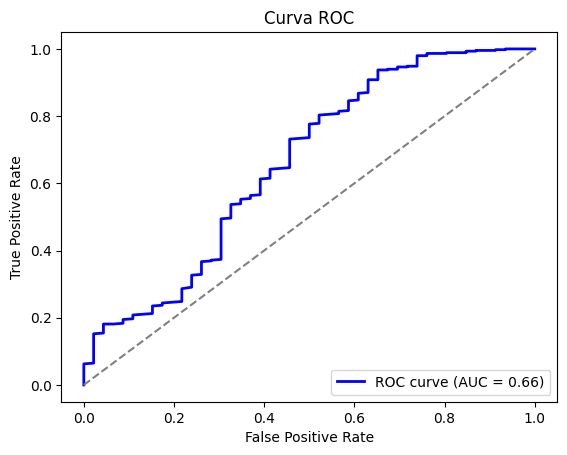

In [8]:


# Cargar el modelo YOLO (ajusta según tu modelo entrenado)
model = YOLO(model_10_path)

# Directorios
images_dir = ROOT_DIR + "data/test/images"
labels_dir = ROOT_DIR + "data/test/labels"

# Obtener lista de imágenes
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
# Función para calcular IoU
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

# Función para calcular el coeficiente de Dice
def dice_coefficient(iou):
    return (2 * iou) / (1 + iou) if iou > 0 else 0

# Listas para AUC-ROC y evaluación
y_true = []
y_scores = []
ious = []
dice_scores = []
false_negatives = 0  # Contador de mariquitas no detectadas

# Evaluar cada imagen
for img_name in image_files:
    img_path = os.path.join(images_dir, img_name)
    label_path = os.path.join(labels_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

    # Cargar imagen
    img = cv2.imread(img_path)
    results = model(img)  # Hacer inferencia con YOLOv10

    # Obtener bounding boxes predichos en YOLOv10
    pred_boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes (x1, y1, x2, y2)
    confidences = results[0].boxes.conf.cpu().numpy()  # Confianza de detección

    # Leer etiquetas (ground truth)
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            gt_boxes = [list(map(float, line.strip().split()[1:])) for line in f]  # YOLO format (x_center, y_center, width, height)

        # Convertir ground truth de formato YOLO a (x1, y1, x2, y2)
        img_w, img_h = img.shape[1], img.shape[0]
        gt_boxes = [[
            (x - w/2) * img_w, (y - h/2) * img_h,
            (x + w/2) * img_w, (y + h/2) * img_h
        ] for x, y, w, h in gt_boxes]

    # Revisar si se detectaron todas las mariquitas
    matched_gt = set()  # Guarda los ground truths que sí fueron detectados

    for gt in gt_boxes:
        best_iou = 0
        best_conf = 0

        for i, pred_box in enumerate(pred_boxes):
            conf_score = confidences[i]  # Obtener confianza

            iou = calculate_iou(pred_box, gt)
            if iou > best_iou:
                best_iou = iou
                best_conf = conf_score

        # Si el IoU es suficiente, consideramos que la detección es válida
        if best_iou > 0.5:  # Threshold de detección correcta
            matched_gt.add(tuple(gt))
        else:
            false_negatives += 1  # No se detectó este ground truth

        # Guardar métricas si hubo una detección
        if best_iou > 0:
            dice = dice_coefficient(best_iou)
            ious.append(best_iou)
            dice_scores.append(dice)

            # Para AUC-ROC
            y_true.append(1)  # Positivo real (la mariquita estaba etiquetada)
            y_scores.append(best_conf)  # Confianza del modelo

    # Falsos positivos (detecciones que no coinciden con ninguna mariquita real)
    for i, pred_box in enumerate(pred_boxes):
        conf_score = confidences[i]

        matched = any(calculate_iou(pred_box, gt) > 0.5 for gt in gt_boxes)
        if not matched:
            y_true.append(0)  # Falso positivo
            y_scores.append(conf_score)

# Calcular métricas finales
iou_mean = np.mean(ious) if ious else 0
dice_mean = np.mean(dice_scores) if dice_scores else 0

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Mostrar resultados
print(f"📊 Promedio IoU: {iou_mean:.4f}")
print(f"🎯 Promedio Dice: {dice_mean:.4f}")
print(f"📈 AUC-ROC: {roc_auc:.4f}")
print(f"🚨 Falsos Negativos (mariquitas no detectadas): {false_negatives}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()



0: 480x640 1 ladybug, 54.3ms
Speed: 2.8ms preprocess, 54.3ms inference, 106.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 ladybug, 54.4ms
Speed: 3.7ms preprocess, 54.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 ladybug, 11.3ms
Speed: 3.5ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 ladybug, 54.2ms
Speed: 2.8ms preprocess, 54.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 ladybug, 14.2ms
Speed: 3.3ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 ladybugs, 11.9ms
Speed: 2.7ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 ladybug, 11.4ms
Speed: 2.8ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 1 ladybug, 54.2ms
Speed: 2.9ms preprocess, 54.2ms inference, 1.3ms postprocess per image at shap

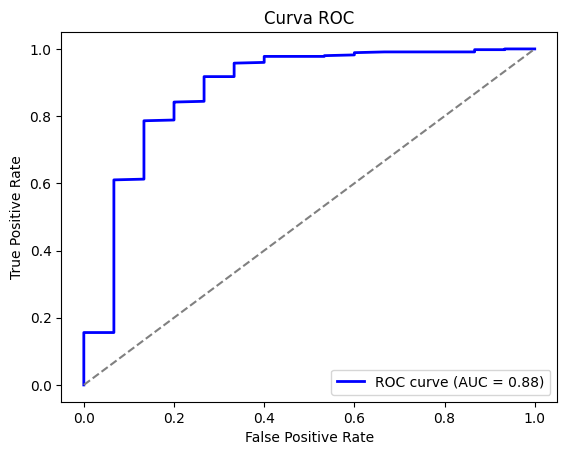

In [9]:


# Cargar el modelo YOLO (ajusta según tu modelo entrenado)
model = YOLO(model_11_path)

# Directorios
images_dir = ROOT_DIR + "data/test/images"
labels_dir = ROOT_DIR + "data/test/labels"

# Obtener lista de imágenes
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
# Función para calcular IoU
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

# Función para calcular el coeficiente de Dice
def dice_coefficient(iou):
    return (2 * iou) / (1 + iou) if iou > 0 else 0

# Listas para AUC-ROC y evaluación
y_true = []
y_scores = []
ious = []
dice_scores = []
false_negatives = 0  # Contador de mariquitas no detectadas

# Evaluar cada imagen
for img_name in image_files:
    img_path = os.path.join(images_dir, img_name)
    label_path = os.path.join(labels_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

    # Cargar imagen
    img = cv2.imread(img_path)
    results = model(img)  # Hacer inferencia con YOLOv10

    # Obtener bounding boxes predichos en YOLOv10
    pred_boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes (x1, y1, x2, y2)
    confidences = results[0].boxes.conf.cpu().numpy()  # Confianza de detección

    # Leer etiquetas (ground truth)
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            gt_boxes = [list(map(float, line.strip().split()[1:])) for line in f]  # YOLO format (x_center, y_center, width, height)

        # Convertir ground truth de formato YOLO a (x1, y1, x2, y2)
        img_w, img_h = img.shape[1], img.shape[0]
        gt_boxes = [[
            (x - w/2) * img_w, (y - h/2) * img_h,
            (x + w/2) * img_w, (y + h/2) * img_h
        ] for x, y, w, h in gt_boxes]

    # Revisar si se detectaron todas las mariquitas
    matched_gt = set()  # Guarda los ground truths que sí fueron detectados

    for gt in gt_boxes:
        best_iou = 0
        best_conf = 0

        for i, pred_box in enumerate(pred_boxes):
            conf_score = confidences[i]  # Obtener confianza

            iou = calculate_iou(pred_box, gt)
            if iou > best_iou:
                best_iou = iou
                best_conf = conf_score

        # Si el IoU es suficiente, consideramos que la detección es válida
        if best_iou > 0.5:  # Threshold de detección correcta
            matched_gt.add(tuple(gt))
        else:
            false_negatives += 1  # No se detectó este ground truth

        # Guardar métricas si hubo una detección
        if best_iou > 0:
            dice = dice_coefficient(best_iou)
            ious.append(best_iou)
            dice_scores.append(dice)

            # Para AUC-ROC
            y_true.append(1)  # Positivo real (la mariquita estaba etiquetada)
            y_scores.append(best_conf)  # Confianza del modelo

    # Falsos positivos (detecciones que no coinciden con ninguna mariquita real)
    for i, pred_box in enumerate(pred_boxes):
        conf_score = confidences[i]

        matched = any(calculate_iou(pred_box, gt) > 0.5 for gt in gt_boxes)
        if not matched:
            y_true.append(0)  # Falso positivo
            y_scores.append(conf_score)

# Calcular métricas finales
iou_mean = np.mean(ious) if ious else 0
dice_mean = np.mean(dice_scores) if dice_scores else 0

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Mostrar resultados
print(f"📊 Promedio IoU: {iou_mean:.4f}")
print(f"🎯 Promedio Dice: {dice_mean:.4f}")
print(f"📈 AUC-ROC: {roc_auc:.4f}")
print(f"🚨 Falsos Negativos (mariquitas no detectadas): {false_negatives}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()



0: 480x640 1 ladybug, 27.6ms
Speed: 2.8ms preprocess, 27.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 ladybug, 26.8ms
Speed: 2.3ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 ladybug, 17.5ms
Speed: 3.3ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 ladybug, 28.2ms
Speed: 2.6ms preprocess, 28.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 ladybug, 21.4ms
Speed: 3.3ms preprocess, 21.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 4 ladybugs, 18.8ms
Speed: 2.5ms preprocess, 18.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 ladybug, 17.6ms
Speed: 2.7ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 1 ladybug, 27.5ms
Speed: 3.0ms preprocess, 27.5ms inference, 1.6ms postprocess per image at shape 

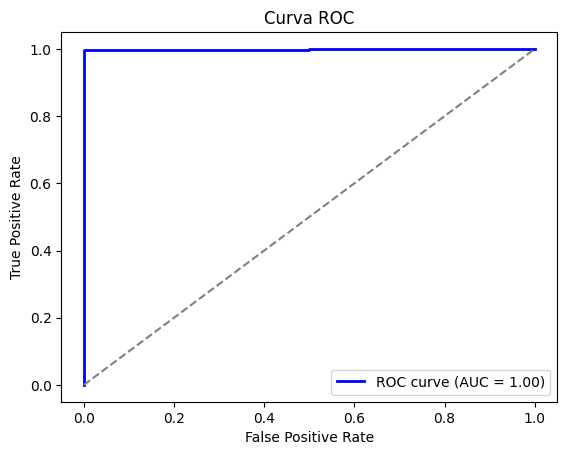

In [11]:


# Cargar el modelo YOLO (ajusta según tu modelo entrenado)
model_12 = ROOT_DIR + 'yolo12/train4/weights/best.pt'
model = YOLO(model_12)

# Directorios
images_dir = ROOT_DIR + "data/test/images"
labels_dir = ROOT_DIR + "data/test/labels"

# Obtener lista de imágenes
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
# Función para calcular IoU
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

# Función para calcular el coeficiente de Dice
def dice_coefficient(iou):
    return (2 * iou) / (1 + iou) if iou > 0 else 0

# Listas para AUC-ROC y evaluación
y_true = []
y_scores = []
ious = []
dice_scores = []
false_negatives = 0  # Contador de mariquitas no detectadas

# Evaluar cada imagen
for img_name in image_files:
    img_path = os.path.join(images_dir, img_name)
    label_path = os.path.join(labels_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

    # Cargar imagen
    img = cv2.imread(img_path)
    results = model(img)  # Hacer inferencia con YOLOv10

    # Obtener bounding boxes predichos en YOLOv10
    pred_boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes (x1, y1, x2, y2)
    confidences = results[0].boxes.conf.cpu().numpy()  # Confianza de detección

    # Leer etiquetas (ground truth)
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            gt_boxes = [list(map(float, line.strip().split()[1:])) for line in f]  # YOLO format (x_center, y_center, width, height)

        # Convertir ground truth de formato YOLO a (x1, y1, x2, y2)
        img_w, img_h = img.shape[1], img.shape[0]
        gt_boxes = [[
            (x - w/2) * img_w, (y - h/2) * img_h,
            (x + w/2) * img_w, (y + h/2) * img_h
        ] for x, y, w, h in gt_boxes]

    # Revisar si se detectaron todas las mariquitas
    matched_gt = set()  # Guarda los ground truths que sí fueron detectados

    for gt in gt_boxes:
        best_iou = 0
        best_conf = 0

        for i, pred_box in enumerate(pred_boxes):
            conf_score = confidences[i]  # Obtener confianza

            iou = calculate_iou(pred_box, gt)
            if iou > best_iou:
                best_iou = iou
                best_conf = conf_score

        # Si el IoU es suficiente, consideramos que la detección es válida
        if best_iou > 0.5:  # Threshold de detección correcta
            matched_gt.add(tuple(gt))
        else:
            false_negatives += 1  # No se detectó este ground truth

        # Guardar métricas si hubo una detección
        if best_iou > 0:
            dice = dice_coefficient(best_iou)
            ious.append(best_iou)
            dice_scores.append(dice)

            # Para AUC-ROC
            y_true.append(1)  # Positivo real (la mariquita estaba etiquetada)
            y_scores.append(best_conf)  # Confianza del modelo

    # Falsos positivos (detecciones que no coinciden con ninguna mariquita real)
    for i, pred_box in enumerate(pred_boxes):
        conf_score = confidences[i]

        matched = any(calculate_iou(pred_box, gt) > 0.5 for gt in gt_boxes)
        if not matched:
            y_true.append(0)  # Falso positivo
            y_scores.append(conf_score)

# Calcular métricas finales
iou_mean = np.mean(ious) if ious else 0
dice_mean = np.mean(dice_scores) if dice_scores else 0

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Mostrar resultados
print(f"📊 Promedio IoU: {iou_mean:.4f}")
print(f"🎯 Promedio Dice: {dice_mean:.4f}")
print(f"📈 AUC-ROC: {roc_auc:.4f}")
print(f"🚨 Falsos Negativos (mariquitas no detectadas): {false_negatives}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.utils import shuffle

In [ ]:
def upsampling(features, target, repeat):
  features_zeros = features[target==0]
  features_ones = features[target==1]

  target_zeros = target[target==0]
  target_ones = target[target==1]

  features_upsample = pd.concat([features_zeros]* [feature_ones] *repeat)
  target_upsample = pd.concat([target_zeros] * [target_ones] *repeat)

  features_upsample, target_upsample = shuffle(features_upsample, target_upsample, random_state=42)

  return features_upsample, target_upsample